In [1]:
from tifffile import imread
import numpy as np
import pandas as pd
from scipy.ndimage import distance_transform_edt as dt
import os, sys
from skimage.measure import regionprops
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# paths 
ppath = '/stanley/WangLab/Connie/02.TEMPOmap/05.revisionQuantification/2022-11-11 Streptavidin-647-biotin-azide on EU-RNA'
segpath = os.path.join(ppath, '3D-segmentation')
samples = ['0h', '1h', '2h', '4h', '6h', '20h', 'ctrl']
tiles = [1, 2, 3, 4]
spl = [1, 0.2841, 0.2841] # voxel size: 0.2841 x 0.2841 x 1 um^3
cutoff = 10 # 10:1

### test

In [3]:
# test on one tile
im = imread(os.path.join(ppath, '0h/tile1/20221111 Streptavidin-647-biotin-azide on EU-RNA_0h_1_z0_ch01.tif')) # reads intensity
nseg = imread(os.path.join(ppath, '3D-segmentation/dapi3Dseg_0h_tile1.tif'))
cseg = imread(os.path.join(ppath, '3D-segmentation/flamingo3Dseg_0h_tile1_erode.tif'))

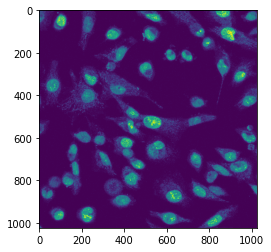

In [4]:
plt.imshow(np.max(im, axis=0))

In [5]:
rp = regionprops(cseg)
intensity = []
for r in rp:
    cb = r.bbox
    cmask = r.image
    nmask = nseg[cb[0]:cb[3], cb[1]:cb[4], cb[2]:cb[5]]
    nmask[nmask!=r.label] = 0
    _im = im[cb[0]:cb[3], cb[1]:cb[4], cb[2]:cb[5]]

    # dt
    cdt = dt(cmask, sampling=spl)
    ndt = dt(np.logical_not(nmask), sampling=spl)
    area = np.logical_xor(cmask, nmask)
    rdt = np.zeros(cdt.shape)
    rdt[area] = ndt[area] / cdt[area]
    rdt1 = np.logical_and(rdt<=cutoff, rdt>0)
    rdt2 = rdt > cutoff
    area1 = np.sum(rdt1)
    area2 = np.sum(rdt2)
    itst1 = np.sum(_im[rdt1])
    itst2 = np.sum(_im[rdt2])
    pct1 = itst1 / (itst1+itst2)
    pct2 = itst2 / (itst1+itst2)
    intensity.append([itst1, itst2, area1, area2, pct1, pct2])
    break

/local/scratch/37615721.1.interactive/ipykernel_194862/3912985116.py:15: RuntimeWarning: invalid value encountered in true_divide
  rdt[area] = ndt[area] / cdt[area]


In [6]:
cdt.shape, rdt.shape

((9, 95, 81), (9, 95, 81))

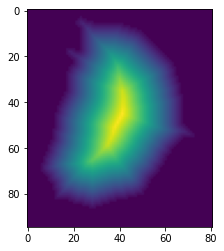

In [7]:
test = dt(cmask[3])
plt.imshow(test)

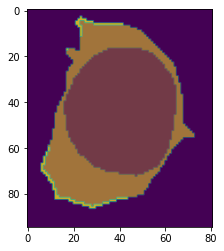

In [8]:
plt.imshow(cmask[3])
# plt.imshow(nmask[3], alpha=0.5)
# plt.imshow(cdt[3], alpha=1)
# plt.imshow(ndt[3], alpha=0.5)
# plt.imshow(rdt[3], alpha=0.5)
plt.imshow(rdt1[3], alpha=0.5)
plt.imshow(rdt2[3], alpha=0.5)

### process

In [14]:
# without nucleus
for s in tqdm([samples[-1]]):
    intensity = []
    for t in tiles[:2]:
        im = imread(os.path.join(ppath, s, f'tile{t}', f'20221111 Streptavidin-647-biotin-azide on EU-RNA_{s}_{t}_z0_ch01.tif')) # reads intensity
        nseg = imread(os.path.join(ppath, f'3D-segmentation/dapi3Dseg_{s}_tile{t}.tif'))
        cseg = imread(os.path.join(ppath, f'3D-segmentation/flamingo3Dseg_{s}_tile{t}_erode.tif'))
        rp = regionprops(cseg)
        for r in rp:
            cb = r.bbox
            cmask = r.image
            nmask = nseg[cb[0]:cb[3], cb[1]:cb[4], cb[2]:cb[5]]
            nmask[nmask!=r.label] = 0
            _im = im[cb[0]:cb[3], cb[1]:cb[4], cb[2]:cb[5]]

            # dt
            cdt = dt(cmask, sampling=spl)
            ndt = dt(np.logical_not(nmask), sampling=spl)
            area = np.logical_xor(cmask, nmask)
            rdt = np.zeros(cdt.shape)
            rdt[area] = ndt[area] / cdt[area]
            rdt_midd = np.logical_and(rdt<=cutoff, rdt>0)
            rdt_peri = rdt > cutoff
            # area
            area_nucl = np.sum(nmask>0)
            area_midd = np.sum(rdt_midd)
            area_peri = np.sum(rdt_peri)
            # intensity
            itst_nucl = np.sum(_im[nmask>0])
            itst_midd = np.sum(_im[rdt_midd])
            itst_peri = np.sum(_im[rdt_peri])
            # percentage
            pct_midd = itst_midd / (itst_midd+itst_peri)
            pct_peri = itst_peri / (itst_midd+itst_peri)
            intensity.append([itst_midd, itst_peri, pct_midd, pct_peri])
    df = pd.DataFrame(intensity, columns=['midd', 'peri', 'midd_pct', 'peri_pct'])
    df.to_csv(os.path.join(ppath, 'DR-output', f'intensity_{s}_112822.csv'))

  0%|                                                     | 0/1 [00:00<?, ?it/s]/local/scratch/37615721.1.interactive/ipykernel_194862/647668295.py:21: RuntimeWarning: invalid value encountered in true_divide
  rdt[area] = ndt[area] / cdt[area]
100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.08s/it]


In [12]:
df

,midd,peri,midd_pct,peri_pct
0,267239,4523,0.983357,0.016643
1,261859,37702,0.874142,0.125858
2,201778,3303,0.983894,0.016106
3,355085,9224,0.974681,0.025319
4,193112,9837,0.951530,0.048470
...,...,...,...,...
82,278750,5015,0.982327,0.017673
83,147780,2345,0.984380,0.015620
84,184629,5028,0.973489,0.026511
85,295699,4361,0.985466,0.014534


In [42]:
# with nucleus
for s in tqdm([samples[-1]]):
    intensity = []
    for t in tiles[:2]:
        im = imread(os.path.join(ppath, s, f'tile{t}', f'20221111 Streptavidin-647-biotin-azide on EU-RNA_{s}_{t}_z0_ch01.tif')) # reads intensity
        nseg = imread(os.path.join(ppath, f'3D-segmentation/dapi3Dseg_{s}_tile{t}.tif'))
        cseg = imread(os.path.join(ppath, f'3D-segmentation/flamingo3Dseg_{s}_tile{t}_erode.tif'))
        rp = regionprops(cseg)
        for r in rp:
            cb = r.bbox
            cmask = r.image
            nmask = nseg[cb[0]:cb[3], cb[1]:cb[4], cb[2]:cb[5]]
            nmask[nmask!=r.label] = 0
            _im = im[cb[0]:cb[3], cb[1]:cb[4], cb[2]:cb[5]]

            # dt
            cdt = dt(cmask, sampling=spl)
            ndt = dt(np.logical_not(nmask), sampling=spl)
            area = np.logical_xor(cmask, nmask)
            rdt = np.zeros(cdt.shape)
            rdt[area] = ndt[area] / cdt[area]
            rdt_midd = np.logical_and(rdt<=cutoff, rdt>0)
            rdt_peri = rdt > cutoff
            # area
            area_nucl = np.sum(nmask>0)
            area_midd = np.sum(rdt_midd)
            area_peri = np.sum(rdt_peri)
            # intensity
            itst_nucl = np.sum(_im[nmask>0])
            itst_midd = np.sum(_im[rdt_midd])
            itst_peri = np.sum(_im[rdt_peri])
            # percentage
            pct_nucl = itst_nucl / (itst_midd+itst_peri+itst_nucl)
            pct_midd = itst_midd / (itst_midd+itst_peri+itst_nucl)
            pct_peri = itst_peri / (itst_midd+itst_peri+itst_nucl)
            intensity.append([itst_nucl, itst_midd, itst_peri, area_nucl, area_midd, area_peri, pct_nucl, pct_midd, pct_peri])
    df = pd.DataFrame(intensity, columns=['nucl', 'midd', 'peri', 'nucl_area', 'midd_area', 'peri_area', 'nucl_pct', 'midd_pct', 'peri_pct'])
    df.to_csv(os.path.join(ppath, 'DR-output', f'intensity_{s}_wNucl_112222.csv'))
    # break

  0%|                                                     | 0/1 [00:00<?, ?it/s]/local/scratch/37561828.1.interactive/ipykernel_212668/3930846882.py:20: RuntimeWarning: invalid value encountered in true_divide
  rdt[area] = ndt[area] / cdt[area]
100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.91s/it]
